In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

In [13]:
import torch
from calflops import calculate_flops
import sophius.utils as utils
import sophius.dataload as dload
from sophius.modelgen import ConvModelGenerator
from sophius.train import train_express_gpu
import torchvision.datasets as dset
import torchvision.transforms as T
from sophius.encode import Encoder
from sophius.utils import calc_model_flops
import sqlite3
import pandas as pd
import seaborn as sns
from tqdm import tqdm

VAL_SIZE = 1024

cifar10 = dset.CIFAR10('../data/CIFAR10', train=True, download=True, transform=T.ToTensor())
cifar_gpu = dload.cifar_to_gpu(cifar10)
loader_gpu = dload.get_loader_gpu(cifar_gpu, val_size=VAL_SIZE, batch_size=1024)

encoder = Encoder()

Files already downloaded and verified


In [16]:
from sophius.train import train_on_gpu

df = pd.DataFrame(columns=['model_id','hash', 'flops', 'params', 'lr', 'num_epoch', 'gamma', 'milestones'])
model_gen = ConvModelGenerator((3, 32, 32), 10, conv_num=10, lin_num=3)


for i in tqdm(range(1000)):
    model_tmpl = model_gen.generate_model_tmpl()
    model = model_tmpl.instantiate_model().type(torch.cuda.FloatTensor)
    flops, params = calc_model_flops(model, (3, 32, 32))
    lr, gamma = 0.01, 0.5
    milestones = [20, 30, 40]
    num_epoch = 50
    res = train_on_gpu(model = model,
                      loader = loader_gpu,
                      milestones = milestones,
                      learning_rate=lr,
                      gamma=gamma,
                      num_epoch = num_epoch,
                      verbose = False)
    
    res['model_id'] = i    
    
    hash_str = encoder.model2hash(model_tmpl) 

    df.loc[i] = [i, hash_str, flops, params, lr, num_epoch, gamma, str(milestones)]

    with sqlite3.connect('../data/models.db') as conn:
        df.loc[i:i].to_sql('040924_params', conn, if_exists='append', index=False)
        res.to_sql('040924_run', conn, if_exists='append', index=False)

#     # print(df.loc[i])

  0% 4/1000 [02:38<10:56:02, 39.52s/it]


KeyboardInterrupt: 

In [67]:
df

,hash,flops,params,lr,num_epoch,gamma,milestones
0,0082020620000000400000000022d00000802206200000...,1055136,102058,0.01,3,0.5,"[20, 30, 40]"


In [52]:
import sqlite3
import pandas as pd

with sqlite3.connect('../data/models.db') as conn:
    df = pd.read_sql('SELECT * FROM conv_10_lin_3_epoch_50', conn)

df.sort_values(by='val_acc', ascending=False, inplace=True)
df

,hex_str,flops,macs,params,time,val_acc,train_acc
930,0080842220000000400000000080412108040000400000...,961733248,480408512,2003755,613.818239,0.813477,0.994141
302,0082082140000000200000000080209210040000008088...,275556800,137555328,824188,258.427490,0.787109,0.976562
23,0082082100491000080800000022c80000802052004920...,48945472,24390976,1144731,177.061507,0.755859,0.996094
763,0080482110080000004910004000000000295000008022...,212892960,106029648,561683,282.491944,0.752930,0.877930
310,0082009110080000002928000100000080004000100200...,12470656,6225408,5552554,13.457602,0.726562,0.918945
...,...,...,...,...,...,...,...
208,0084020508080000008050061004000000821009004260...,21729184,10858496,10761994,164.906045,0.195312,0.284180
129,0080500608040000400000000028b00000449000001000...,448672,200704,181035,16.418530,0.192383,0.167969
115,0082011210080000400000000023480000880061200000...,4776752,2363776,92251,29.879237,0.176758,0.184570
408,0088010520000000400000000028c80000802805200000...,403224,199384,172922,15.385370,0.169922,0.196289


In [3]:
from sophius.encode import Encoder, str_to_vec
from sophius.templates import ModelTmpl, LinearTmpl, Conv2dTmpl

encoder = Encoder()

C:\Users\korol\miniforge3\envs\sophius\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [53]:
df['model'] = df['hex_str'].apply(encoder.hash2model, in_shape=(3, 32, 32), out_shape=10)

In [54]:
for i, row in df[:10].iterrows():
    stats = "idx: {:<7} {:18} {:12} {:8}".format(
        i,
        f"val_acc: {row['val_acc']:.3f}" ,
        f"flops: {row['flops'] // 1024 // 1024:}M",
        f"params: {row['params'] / 1024 / 1024:.2f}M",
    )
    
    print(stats)
    print(row['model'])
    print("="*80)

idx: 930     val_acc: 0.813     flops: 917M  params: 1.91M
Conv2d       (96, 32, 32)   (3, 3)   (1, 1)  
ReLU         (96, 32, 32)  
BatchNorm2d  (96, 32, 32)  
Conv2d       (128, 28, 28)  (5, 5)   (1, 1)  
PReLU        (128, 28, 28) 
BatchNorm2d  (128, 28, 28) 
Conv2d       (192, 14, 14)  (7, 7)   (2, 2)  
LeakyReLU    (192, 14, 14)  (0.01)  
AvgPool2d    (192, 14, 14)  (3, 3)   (1, 1)  
Conv2d       (64, 5, 5)     (1, 1)   (3, 3)  
BatchNorm2d  (64, 5, 5)    
AvgPool2d    (64, 3, 3)     (3, 3)   (2, 2)  
PReLU        (64, 3, 3)    
Conv2d       (128, 2, 2)    (2, 2)   (2, 2)  
LeakyReLU    (128, 2, 2)    (0.1)   
AvgPool2d    (128, 2, 2)    (2, 2)   (2, 2)  
Conv2d       (96, 1, 1)     (6, 6)   (4, 4)  
GlobalAvgPool2d (96, 1, 1)    
Flatten      96            
Linear       10            

idx: 302     val_acc: 0.787     flops: 262M  params: 0.79M
Conv2d       (32, 31, 31)   (2, 2)   (1, 1)  
BatchNorm2d  (32, 31, 31)  
ReLU         (32, 31, 31)  
Conv2d       (192, 16, 16)  (6, 6)  

In [56]:
df.loc[310, 'model'].instantiate_model()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2))
  (1): LeakyReLU(negative_slope=0.1)
  (2): AvgPool2d(kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=5408, out_features=1024, bias=True)
  (5): LeakyReLU(negative_slope=0.001)
  (6): Dropout(p=0.75, inplace=False)
  (7): Linear(in_features=1024, out_features=10, bias=True)
)

# Plot best results

In [ ]:
from sophius.train import train_on_gpu, train_express_gpu

In [59]:
df.head()

,hex_str,flops,macs,params,time,val_acc,train_acc,model,templates
930,0080842220000000400000000080412108040000400000...,961733248,480408512,2003755,613.818239,0.813477,0.994141,"Conv2d (96, 32, 32) (3, 3) (1, 1) \...","[Conv2d None (3, 3) (1, 1) ..."
302,0082082140000000200000000080209210040000008088...,275556800,137555328,824188,258.427490,0.787109,0.976562,"Conv2d (32, 31, 31) (2, 2) (1, 1) \...","[Conv2d None (2, 2) (1, 1) ..."
23,0082082100491000080800000022c80000802052004920...,48945472,24390976,1144731,177.061507,0.755859,0.996094,"Conv2d (32, 31, 31) (2, 2) (1, 1) \...","[Conv2d None (2, 2) (1, 1) ..."
763,0080482110080000004910004000000000295000008022...,212892960,106029648,561683,282.491944,0.752930,0.877930,"Conv2d (128, 31, 31) (2, 2) (1, 1) \...","[Conv2d None (2, 2) (1, 1) ..."
310,0082009110080000002928000100000080004000100200...,12470656,6225408,5552554,13.457602,0.726562,0.918945,"Conv2d (32, 14, 14) (6, 6) (2, 2) \...","[Conv2d None (6, 6) (2, 2) ..."


In [57]:
df[df['params'] < 100000]

,hex_str,flops,macs,params,time,val_acc,train_acc,model,templates
890,008082210044600008040000008400a210080000002530...,21327104,10573184,60971,45.490575,0.689453,0.687500,"Conv2d (96, 29, 29) (4, 4) (1, 1) \...","[Conv2d None (4, 4) (1, 1) ..."
517,0081102240000000004910001002000000840092004450...,19870960,9766144,71754,89.360929,0.684570,0.792969,"Conv2d (64, 32, 32) (1, 1) (1, 1) \...","[Conv2d None (1, 1) (1, 1) ..."
647,008401120042a000200000004000000000808421002550...,2089424,1031616,62218,12.003363,0.673828,0.762695,"Conv2d (16, 16, 16) (5, 5) (2, 2) \...","[Conv2d None (5, 5) (2, 2) ..."
877,0080204a100200000082042210080000400000000028c8...,20301856,10117440,95338,24.135697,0.670898,0.823242,"Conv2d (192, 11, 11) (7, 7) (3, 3) \...","[Conv2d None (7, 7) (3, 3) ..."
371,008202211002000000820422400000000042a000200000...,18489024,9153984,24427,40.766261,0.663086,0.728516,"Conv2d (32, 29, 29) (4, 4) (1, 1) \...","[Conv2d None (4, 4) (1, 1) ..."
...,...,...,...,...,...,...,...,...,...
52,00804412100800000024a8000048600000881005010000...,1915336,905216,24403,17.826802,0.243164,0.247070,"Conv2d (128, 16, 16) (3, 3) (2, 2) \...","[Conv2d None (3, 3) (2, 2) ..."
274,008810060022a800200000004000000020000000001000...,4616,1616,138,9.246439,0.243164,0.238281,"Conv2d (8, 8, 8) (1, 1) (4, 4) \...","[Conv2d None (1, 1) (4, 4) ..."
462,00881006100400000028c8000081100620000000008210...,296608,146176,45260,21.441042,0.222656,0.213867,"Conv2d (8, 8, 8) (1, 1) (4, 4) \...","[Conv2d None (1, 1) (4, 4) ..."
451,008040860044a000002948004000000010080000008090...,2612672,1285632,82955,17.752853,0.201172,0.216797,"Conv2d (128, 9, 9) (6, 6) (4, 4) \...","[Conv2d None (6, 6) (4, 4) ..."


In [14]:
tmpl = df.model.loc[513]
model = tmpl.instantiate_model().type(torch.cuda.FloatTensor)
tmpl

Conv2d       (16, 32, 32)   (3, 3)   (1, 1)  
LeakyReLU    (16, 32, 32)   (0.01)  
MaxPool2d    (16, 33, 33)   (2, 2)   (1, 1)  
AvgPool2d    (16, 17, 17)   (4, 4)   (2, 2)  
Conv2d       (16, 9, 9)     (3, 3)   (2, 2)  
PReLU        (16, 9, 9)    
AvgPool2d    (16, 5, 5)     (4, 4)   (2, 2)  
BatchNorm2d  (16, 5, 5)    
Conv2d       (16, 2, 2)     (2, 2)   (4, 4)  
BatchNorm2d  (16, 2, 2)    
ReLU         (16, 2, 2)    
GlobalAvgPool2d (16, 1, 1)    
Flatten      16            
Linear       10            

Loss 39.971: 100%|██████████| 50/50 [01:38<00:00,  1.98s/it]


val_acc: 0.681, train_acc: 0.686


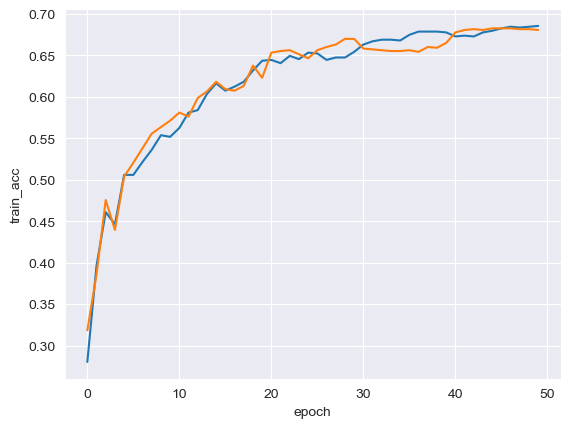

In [58]:
tmpl = df.model[890]
model = tmpl.instantiate_model().type(torch.cuda.FloatTensor)

res = train_on_gpu(model = model,                  
                   loader = loader_gpu,
                   learning_rate=0.01,
                   gamma=0.5,
                   milestones = [20, 30, 40],
                   num_epoch = 50,
                   verbose = True)

sns.lineplot(res, x = 'epoch', y = 'train_acc')
sns.lineplot(res, x = 'epoch', y = 'val_acc');

In [60]:
res

,epoch,loss,train_acc,val_acc,time
0,0.0,84.660730,0.280273,0.318359,2.382275
1,1.0,98.448102,0.396484,0.385742,4.357108
2,2.0,75.483432,0.460938,0.475586,6.317469
3,3.0,75.617128,0.446289,0.439453,8.299763
4,4.0,69.243143,0.505859,0.503906,10.277779
5,5.0,66.575659,0.505859,0.520508,12.283171
6,6.0,64.223872,0.521484,0.538086,14.230724
7,7.0,61.952117,0.536133,0.555664,16.171982
8,8.0,60.930063,0.553711,0.563477,18.116658
9,9.0,59.818451,0.551758,0.571289,20.056530


Loss 39.984: 100%|██████████| 50/50 [01:13<00:00,  1.46s/it]


Finished in 1m 13.1s 
Loss: 39.984
val_acc: 0.682, train_acc: 0.679


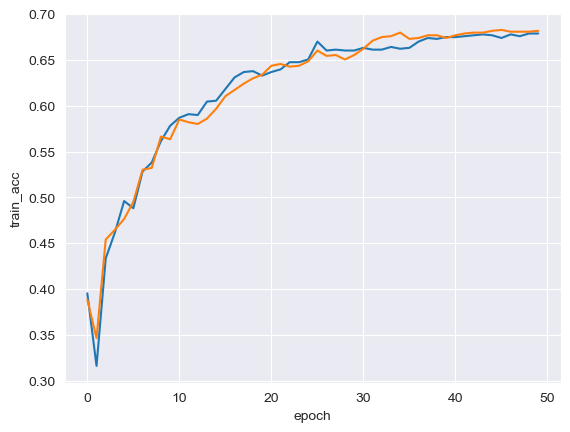

In [51]:
tmpl = df.model[371]
model = tmpl.instantiate_model().type(torch.cuda.FloatTensor)

res = train_on_gpu(model = model,                  
                   loader = loader_gpu,
                   learning_rate=0.01,
                   gamma=0.5,
                   milestones = [10, 25, 35],
                   num_epoch = 50,
                   verbose = True)

sns.lineplot(res, x = 'epoch', y = 'train_acc')
sns.lineplot(res, x = 'epoch', y = 'val_acc');

Loss 40.573: 100%|██████████| 50/50 [01:13<00:00,  1.46s/it]


val_acc: 0.672, train_acc: 0.684


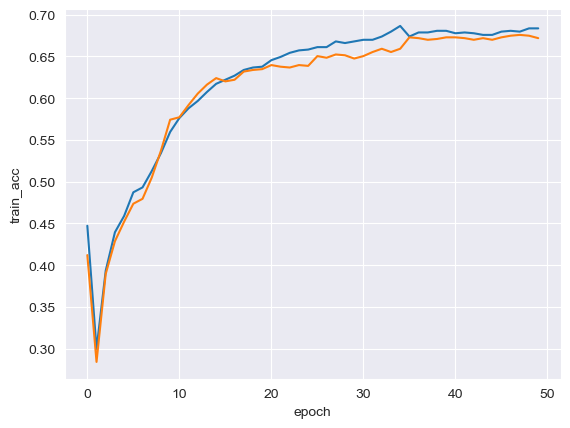

In [55]:
tmpl = df.model[371]
model = tmpl.instantiate_model().type(torch.cuda.FloatTensor)

res = train_on_gpu(model = model,    
                   loader = loader_gpu,
                   learning_rate = 0.01,
                   gamma = 0.5,
                   milestones = [10, 25, 35],
                   num_epoch = 50,
                   verbose = True)

sns.lineplot(res, x = 'epoch', y = 'train_acc')
sns.lineplot(res, x = 'epoch', y = 'val_acc');

Loss 42.676: 100%|██████████| 50/50 [01:12<00:00,  1.46s/it]


val_acc: 0.669, train_acc: 0.684


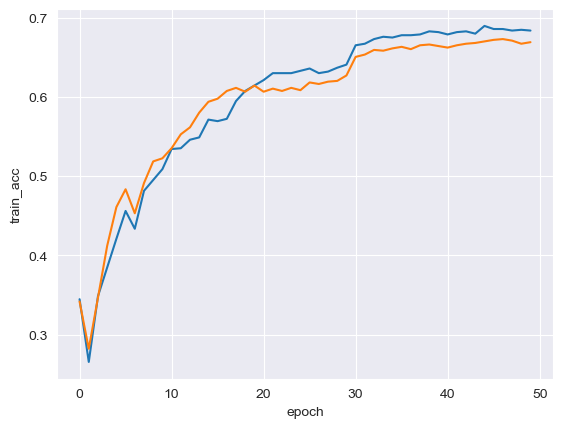

In [54]:
tmpl = df.model[371]
model = tmpl.instantiate_model().type(torch.cuda.FloatTensor)

res = train_on_gpu(model = model,                  
                   loader = loader_gpu,
                   learning_rate=0.01,
                   gamma=0.5,
                   milestones = [20, 30, 40],
                   num_epoch = 50,
                   verbose = True)

sns.lineplot(res, x = 'epoch', y = 'train_acc')
sns.lineplot(res, x = 'epoch', y = 'val_acc');

Loss 56.390: 100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


Finished in 29.6s 
Loss: 56.390
val_acc: 0.572, train_acc: 0.558


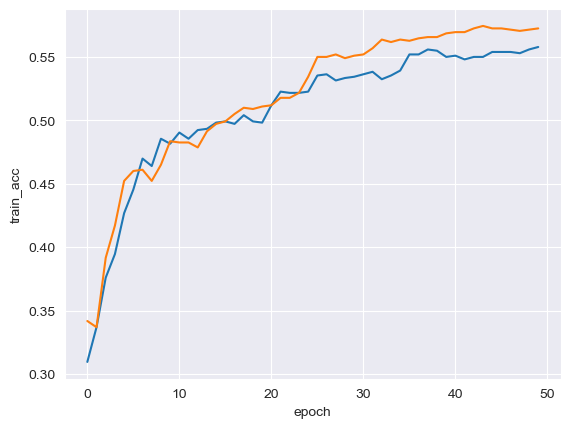

In [52]:
tmpl = df.model[513]
model = tmpl.instantiate_model().type(torch.cuda.FloatTensor)

res = train_on_gpu(model = model,                  
                   loader = loader_gpu,
                   learning_rate=0.01,
                   gamma=0.5,
                   milestones = [10, 25, 35],
                   num_epoch = 50,
                   verbose = True)

sns.lineplot(res, x = 'epoch', y = 'train_acc')
sns.lineplot(res, x = 'epoch', y = 'val_acc');

Loss 51.173: 100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


val_acc: 0.609, train_acc: 0.612


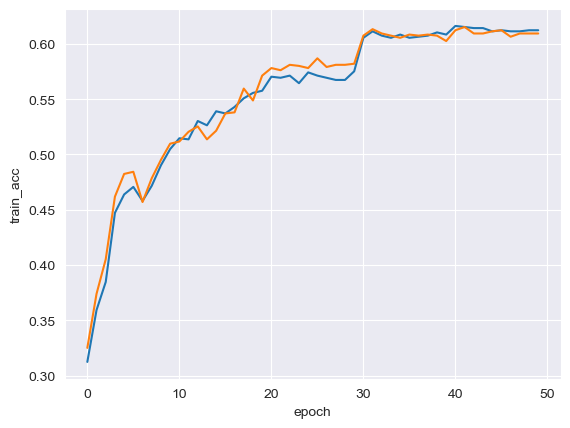

In [56]:
tmpl = df.model[513]
model = tmpl.instantiate_model().type(torch.cuda.FloatTensor)

res = train_on_gpu(model = model,                  
                   loader = loader_gpu,
                   learning_rate=0.01,
                   gamma=0.5,
                   milestones = [20, 30, 40],
                   num_epoch = 50,
                   verbose = True)

sns.lineplot(res, x = 'epoch', y = 'train_acc')
sns.lineplot(res, x = 'epoch', y = 'val_acc');

Finished in 29.6s 13 30s
Loss: 59.013
val_acc: 0.563, train_acc: 0.542


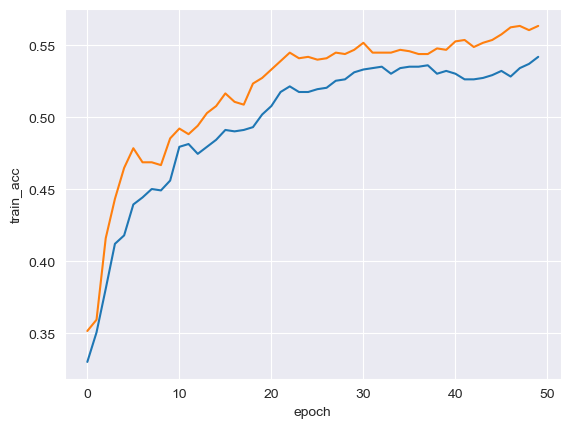

In [37]:
tmpl = df.model[513]
model = tmpl.instantiate_model().type(torch.cuda.FloatTensor)

res = train_on_gpu(model = model,                  
                   loader = loader_gpu,
                   learning_rate=0.05,
                   gamma=0.1,
                   milestones = [20],
                   num_epoch = 50,
                   verbose = True)

sns.lineplot(res, x = 'epoch', y = 'train_acc')
sns.lineplot(res, x = 'epoch', y = 'val_acc');

Finished in 30.1s 45 30s
Loss: 51.845
val_acc: 0.602, train_acc: 0.594


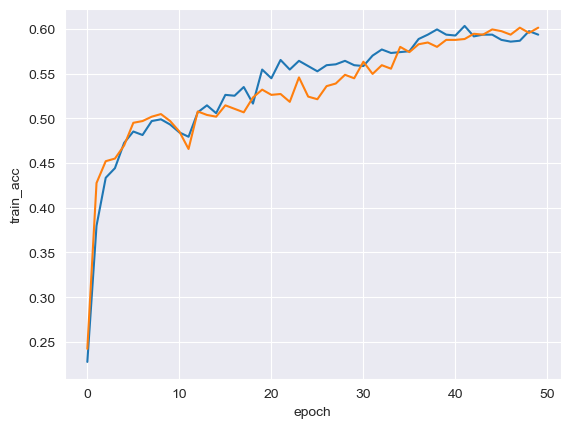

In [38]:
res = train_on_gpu(model = model,                  
                   loader = loader_gpu,
                   learning_rate=0.01,
                   gamma=0.1,
                   milestones = [],
                   num_epoch = 50,
                   verbose = True)

sns.lineplot(res, x = 'epoch', y = 'train_acc')
sns.lineplot(res, x = 'epoch', y = 'val_acc');

Finished in 29.9s 88 		 30s
Loss: 51.588
val_acc: 0.611, train_acc: 0.611


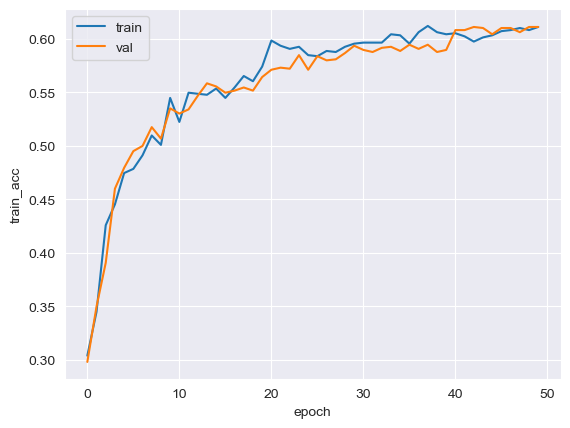

In [45]:
res = train_on_gpu(model = model,                  
                   loader = loader_gpu,
                   learning_rate=0.01,
                   gamma=0.5,
                   milestones = [20, 40],
                   num_epoch = 50,
                   verbose = True)

sns.lineplot(res, x = 'epoch', y = 'train_acc', label='train')
sns.lineplot(res, x = 'epoch', y = 'val_acc', label='val');

Finished in 30.2s 26 		 30s
Loss: 51.526
val_acc: 0.624, train_acc: 0.595


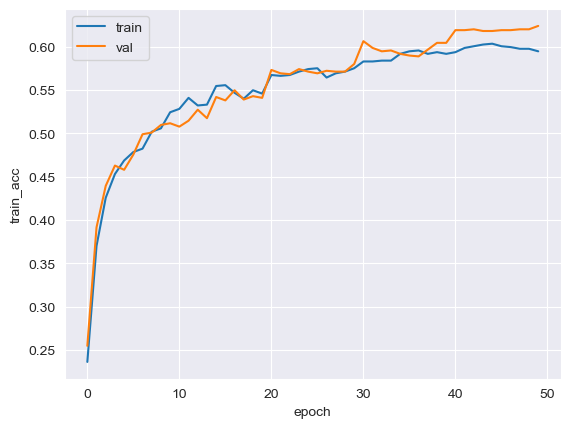

In [46]:
res = train_on_gpu(model = model,                  
                   loader = loader_gpu,
                   learning_rate=0.01,
                   gamma=0.5,
                   milestones = [20, 30, 40],
                   num_epoch = 50,
                   verbose = True)

sns.lineplot(res, x = 'epoch', y = 'train_acc', label='train')
sns.lineplot(res, x = 'epoch', y = 'val_acc', label='val');

Finished in 58.8s 197 		 59s
Loss: 49.197
val_acc: 0.628, train_acc: 0.609


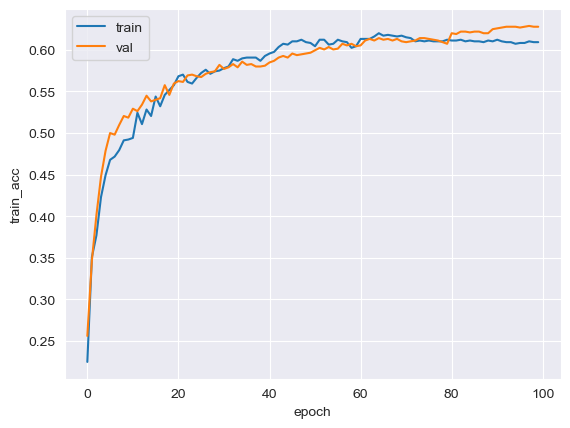

In [44]:
res = train_on_gpu(model=model,
                   loader=loader_gpu,
                   learning_rate=0.01,
                   gamma=0.5,
                   milestones = [20, 40, 60, 80, 100],
                   num_epoch = 100,
                   verbose = True)

sns.lineplot(res, x = 'epoch', y = 'train_acc', label='train')
sns.lineplot(res, x = 'epoch', y = 'val_acc', label='val');

Finished in 59.4s 966 		 59s
Loss: 46.966
val_acc: 0.625, train_acc: 0.612


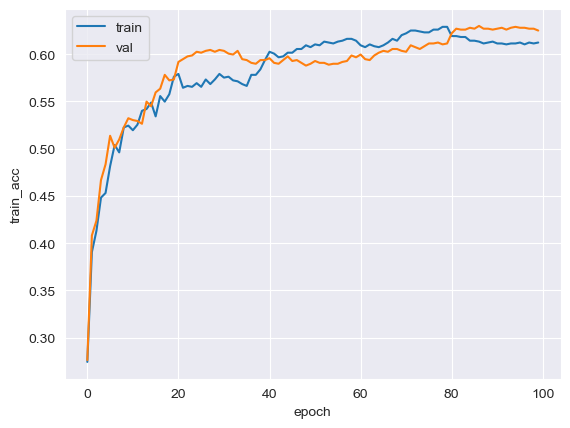

In [43]:
res = train_on_gpu(model=model,                  
                   loader=loader_gpu,
                   learning_rate=0.01,
                   gamma=0.5,
                   milestones = [20, 40, 80],
                   num_epoch = 100,
                   verbose = True)

sns.lineplot(res, x = 'epoch', y = 'train_acc', label='train')
sns.lineplot(res, x = 'epoch', y = 'val_acc', label='val');

Finished in 1m 28.7s 0 		 89s
Loss: 48.510
val_acc: 0.626, train_acc: 0.631


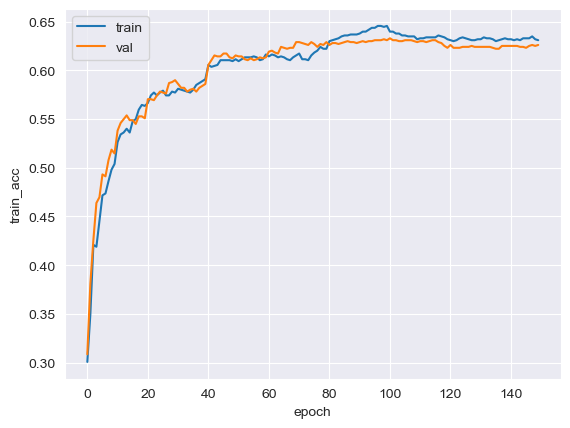

In [48]:
res = train_on_gpu(model=model,
                   loader=loader_gpu,
                   learning_rate=0.01,
                   gamma=0.5,
                   milestones = [10, 20, 40, 80, 100],
                   num_epoch = 150,
                   verbose = True)

sns.lineplot(res, x = 'epoch', y = 'train_acc', label='train')
sns.lineplot(res, x = 'epoch', y = 'val_acc', label='val');